In [33]:
    # Import libraries
import jax
import jax.numpy as jnp
from jax import jit, grad, value_and_grad
from jax.nn import relu, sigmoid
from jax.random import PRNGKey, normal, split
from functools import partial
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import optax
import numpy as np
from scipy.stats import norm  # For the inverse CDF (ppf)
# TPU setup
print(jax.devices())


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [34]:
class VariationalAutoencoder:
    def __init__(self, input_size, hidden_sizes, latent_size, rng_key):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.latent_size = latent_size
        self.rng_key = rng_key

        # Initialize parameters
        self.params = self.initialize_parameters()

        # Initialize optimizer with gradient clipping
        self.optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients to global norm of 1.0
            optax.adam(learning_rate=1e-4)    # Reduced learning rate
        )
        self.opt_state = self.optimizer.init(self.params)
    def encode(self, params, key, x):
        mu, logvar = self.encoder(params, x)
        return mu, logvar

    def generate_grid(self, params, n=15, digit_size=28):
        """
        Generates a grid of digit images by traversing the 2D latent space.

        Args:
            params: Trained model parameters.
            n (int): Number of points per latent dimension.
            digit_size (int): Size of each digit image (28 for MNIST).

        Returns:
            figure (np.ndarray): A large image containing the grid of generated digits.
        """
        # Create linearly spaced coordinates on the unit square, transformed through the inverse CDF (ppf) of the Gaussian
        grid_x = norm.ppf(jnp.linspace(0.05, 0.95, n))
        grid_y = norm.ppf(jnp.linspace(0.05, 0.95, n))

        # Create a meshgrid
        grid_z = jnp.array([[xi, yi] for yi in grid_y for xi in grid_x])  # Shape: (n*n, 2)

        # Decode the grid_z to get generated images
        # jit the decoder for performance
        @jit
        def decode_batch(params, z):
            return self.decoder(params, z)

        decoded = decode_batch(params, grid_z)  # Shape: (n*n, 784)

        # Reshape decoded images to (n*n, 28, 28)
        decoded = decoded.reshape((n * n, digit_size, digit_size))

        # Convert to NumPy for plotting
        decoded = np.array(decoded)

        # Initialize a large grid to place each digit
        figure = np.zeros((digit_size * n, digit_size * n))

        for i in range(n):
            for j in range(n):
                digit = decoded[i * n + j]
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        return figure
    def initialize_parameters(self):
        params = {}
        keys = split(self.rng_key, len(self.hidden_sizes) * 2 + 4)

        # Encoder weights and biases
        in_dim = self.input_size
        for i, out_dim in enumerate(self.hidden_sizes):
            W_key, b_key = split(keys[i])
            # He initialization for ReLU
            params[f'encoder_W{i+1}'] = jax.random.normal(W_key, (out_dim, in_dim)) * jnp.sqrt(2.0 / in_dim)
            params[f'encoder_b{i+1}'] = jnp.zeros((out_dim,))
            in_dim = out_dim

        # Mean and log variance weights and biases
        mu_W_key, mu_b_key = split(keys[len(self.hidden_sizes)])
        params['mu_W'] = jax.random.normal(mu_W_key, (self.latent_size, in_dim)) * jnp.sqrt(2.0 / in_dim)
        params['mu_b'] = jnp.zeros((self.latent_size,))
        logvar_W_key, logvar_b_key = split(keys[len(self.hidden_sizes) + 1])
        params['logvar_W'] = jax.random.normal(logvar_W_key, (self.latent_size, in_dim)) * jnp.sqrt(2.0 / in_dim)
        params['logvar_b'] = jnp.zeros((self.latent_size,))

        # Decoder weights and biases
        in_dim = self.latent_size
        for i, out_dim in enumerate(reversed(self.hidden_sizes)):
            W_key, b_key = split(keys[len(self.hidden_sizes) + 2 + i])
            # He initialization for ReLU
            params[f'decoder_W{i+1}'] = jax.random.normal(W_key, (out_dim, in_dim)) * jnp.sqrt(2.0 / in_dim)
            params[f'decoder_b{i+1}'] = jnp.zeros((out_dim,))
            in_dim = out_dim

        # Output layer weights and biases
        decoder_W_out_key, decoder_b_out_key = split(keys[-2])
        # Xavier initialization for sigmoid
        params['decoder_W_out'] = jax.random.normal(decoder_W_out_key, (self.input_size, in_dim)) * jnp.sqrt(1.0 / in_dim)
        params['decoder_b_out'] = jnp.zeros((self.input_size,))

        return params

    def encoder(self, params, x):
        h = x
        for i in range(len(self.hidden_sizes)):
            W = params[f'encoder_W{i+1}']
            b = params[f'encoder_b{i+1}']
            h = relu(jnp.dot(h, W.T) + b)
        mu = jnp.dot(h, params['mu_W'].T) + params['mu_b']
        logvar = jnp.dot(h, params['logvar_W'].T) + params['logvar_b']
        return mu, logvar

    def reparameterize(self, key, mu, logvar):
        std = jnp.exp(0.5 * logvar)
        eps = normal(key, std.shape)
        return mu + eps * std

    def decoder(self, params, z):
        h = z
        for i in range(len(self.hidden_sizes)):
            W = params[f'decoder_W{i+1}']
            b = params[f'decoder_b{i+1}']
            h = relu(jnp.dot(h, W.T) + b)
        y = sigmoid(jnp.dot(h, params['decoder_W_out'].T) + params['decoder_b_out'])
        return y

    def forward(self, params, key, x):
        mu, logvar = self.encoder(params, x)
        z = self.reparameterize(key, mu, logvar)
        y = self.decoder(params, z)
        return y, mu, logvar

    def loss_function(self, params, key, x):
        y, mu, logvar = self.forward(params, key, x)
        # Reconstruction loss (binary cross-entropy)
        bce = -jnp.sum(x * jnp.log(y + 1e-9) + (1 - x) * jnp.log(1 - y + 1e-9), axis=1)
        # KL divergence
        kl = -0.5 * jnp.sum(1 + logvar - mu ** 2 - jnp.exp(logvar), axis=1)
        return jnp.mean(bce + kl)

    @partial(jit, static_argnums=(0,))
    def train_step(self, params, opt_state, key, x):
        loss, grads = value_and_grad(self.loss_function)(params, key, x)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    def train(self, X, batch_size=128, epochs=100):
        num_samples = X.shape[0]
        num_batches = num_samples // batch_size

        for epoch in range(epochs):
            # Shuffle the data
            self.rng_key, subkey = split(self.rng_key)
            perm = jax.random.permutation(subkey, num_samples)
            X_shuffled = X[perm]

            epoch_loss = 0.0
            for i in range(num_batches):
                batch_X = X_shuffled[i * batch_size:(i + 1) * batch_size]
                self.rng_key, subkey = split(self.rng_key)
                self.params, self.opt_state, loss = self.train_step(self.params, self.opt_state, subkey, batch_X)
                epoch_loss += loss

            avg_loss = epoch_loss / num_batches
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")


In [35]:
# Data loading and preprocessing
def load_data():
    # Load the MNIST dataset
    (X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

    # Normalize the data to [0, 1]
    X_train_full = X_train_full.astype(jnp.float32) / 255.0
    X_test_full = X_test_full.astype(jnp.float32) / 255.0

    # Flatten the images to vectors of size 784
    X_train_full = X_train_full.reshape(-1, 28 * 28)
    X_test_full = X_test_full.reshape(-1, 28 * 28)

    # Convert to JAX arrays
    X_train_full = jnp.array(X_train_full)
    X_test_full = jnp.array(X_test_full)

    # Convert labels to JAX arrays
    y_train_full = jnp.array(y_train_full)
    y_test_full = jnp.array(y_test_full)

    return X_train_full, y_train_full, X_test_full, y_test_full

# Plot reconstructed images
def plot_reconstructed_images(vae, X_test, num_images=10):
    rng_key = PRNGKey(42)
    sample_images = X_test[:num_images]
    y, _, _ = vae.forward(vae.params, rng_key, sample_images)
    y = y.reshape(-1, 28, 28)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images, 2))
    for i in range(num_images):
        axes[0, i].imshow(sample_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(y[i], cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Generate new images
def generate_images(vae, num_images=10):
    rng_key = PRNGKey(100)
    z = normal(rng_key, (num_images, vae.latent_size))
    y = vae.decoder(vae.params, z)
    y = y.reshape(-1, 28, 28)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(y[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

# Plot 2d latent space
def plot_latent_space(latent_mu, y, num_classes=10):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_mu[:, 0], latent_mu[:, 1], c=y, cmap='tab10', alpha=0.6, s=15)
    plt.colorbar(scatter, ticks=range(num_classes))
    plt.grid(True)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space of VAE')
    plt.show()

def get_latent_representations(vae, X, batch_size=128):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size + int(num_samples % batch_size != 0)
    latent_mu = []
    latent_logvar = []

    for i in range(num_batches):
        batch_X = X[i * batch_size : (i + 1) * batch_size]
        vae.rng_key, subkey = split(vae.rng_key)
        mu, logvar = vae.encode(vae.params, subkey, batch_X)
        latent_mu.append(mu)
        latent_logvar.append(logvar)

    # Concatenate all batches
    latent_mu = jnp.concatenate(latent_mu, axis=0)
    latent_logvar = jnp.concatenate(latent_logvar, axis=0)

    return latent_mu, latent_logvar

In [36]:
# Load data
X_train, y_train, X_test, y_test = load_data()

# Instantiate the VAE
input_size = 784  # 28x28 pixels
hidden_sizes = [512, 256]  # Hidden layers sizes
latent_size = 2  # Latent space dimension
rng_key = PRNGKey(0)

vae = VariationalAutoencoder(input_size, hidden_sizes, latent_size, rng_key)

# Train the VAE
vae.train(X_train, batch_size=128, epochs=100)

Epoch 1/100, Loss: 219.0232
Epoch 11/100, Loss: 158.5214
Epoch 21/100, Loss: 153.6478
Epoch 31/100, Loss: 150.5823
Epoch 41/100, Loss: 148.2780
Epoch 51/100, Loss: 146.4857
Epoch 61/100, Loss: 145.0777
Epoch 71/100, Loss: 143.8476
Epoch 81/100, Loss: 142.8834
Epoch 91/100, Loss: 142.0489
Epoch 100/100, Loss: 141.3780


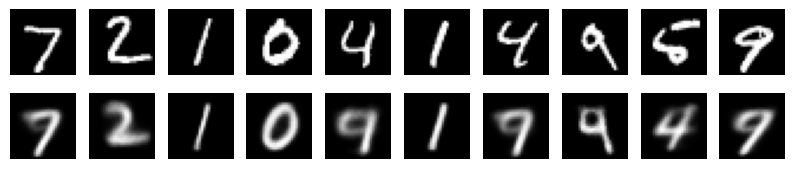

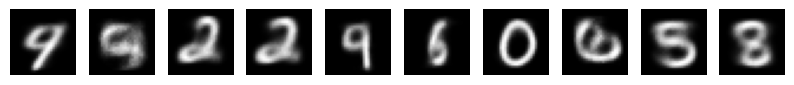

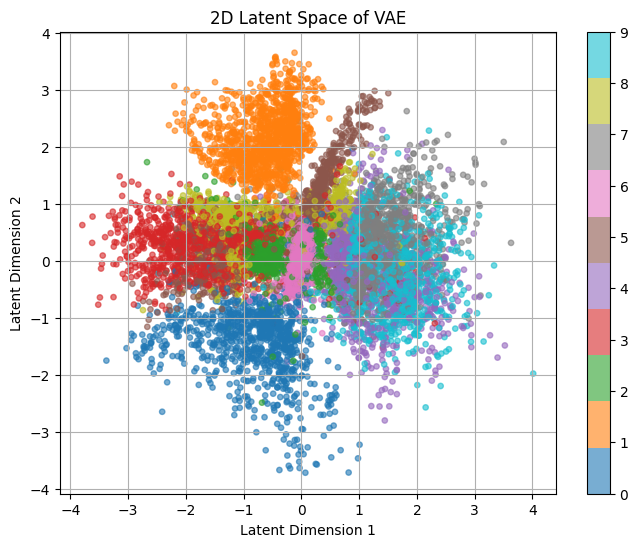

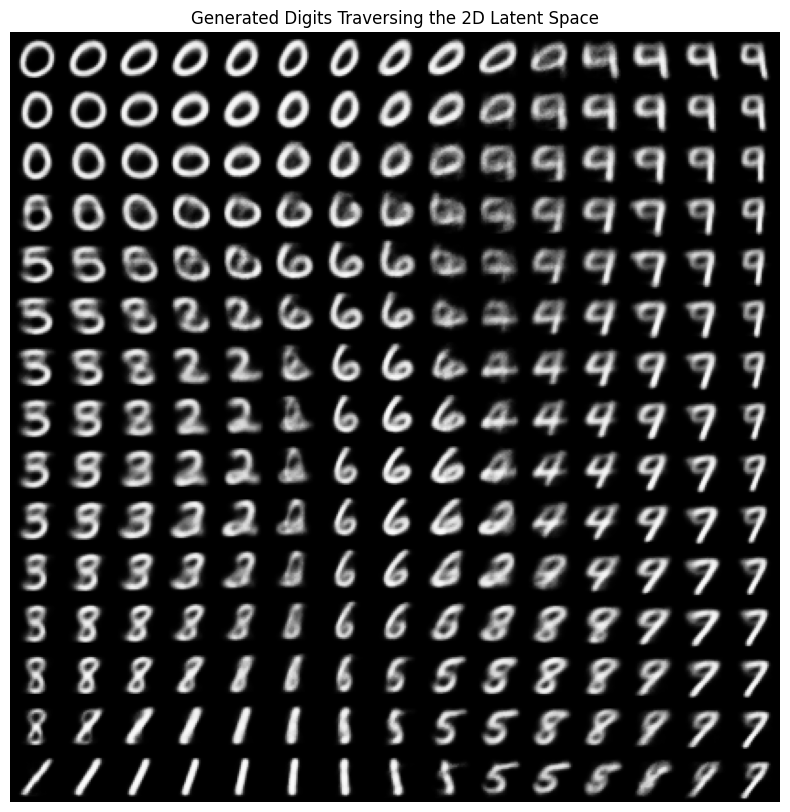

In [37]:
# Plot reconstructed images
plot_reconstructed_images(vae, X_test)
# Generate new images
generate_images(vae)
# Encode the test data to get latent representations
latent_mu, latent_logvar = get_latent_representations(vae, X_test, batch_size=128)
# Plot the 2D latent space
plot_latent_space(latent_mu, y_test, num_classes=10)

# Generate and plot the grid of digits traversing the latent space
grid_image = vae.generate_grid(vae.params, n=15, digit_size=28)

plt.figure(figsize=(10, 10))
plt.imshow(grid_image, cmap='Greys_r')
plt.axis('off')
plt.title('Generated Digits Traversing the 2D Latent Space')
plt.show()